In [6]:
from localization_scripts.imports import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filename = '/home/smlm-workstation/event-smlm/our_ev_smlm_recordings/MT_5May_S2_reduced_bias_580sec/MT_5May_S2_reduced_bias_580sec.raw'
if os.path.basename(filename)[-4:] == ".raw":
    events = raw_events_to_array(filename).astype(
        [("x", "uint16"), ("y", "uint16"), ("p", "byte"), ("t", "uint64")]
    )

slice = events[(events["t"] < 50e6)]

In [3]:
# from localization_scripts.event_array_processing import array_to_polarity_map
NUM_CORES = multiprocessing.cpu_count()

"""PROMINENCE is the prominence of the peaks in the convolved signals.
Smaller value detects more peaks, increasing the evaluation time."""
PROMINENCE = 25

"""DATASEET_FWHM is the FWHM of the PSF in the dataset in pixels."""
DATASEET_FWHM = 6

"""PEAK_TIME_THRESHOLD is the maximum time difference between two peaks in order to be considered as the same peak."""
PEAK_TIME_THRESHOLD = 40e3

"""PEAK_NEIGHBORS is the number of neighboring pixels to be considered when filtering same peaks."""
PEAK_NEIGHBORS = 7

"""ROI_RADIUS is the radius of the generated ROI in pixels."""
ROI_RADIUS = 6

events = slice
start_time = time.time()

# Get the minimum and maximum x and y coordinates
min_x = events["x"].min()
min_y = events["y"].min()
max_x = events["x"].max()
max_y = events["y"].max()

# Create coordinate lists
y_coords, x_coords = [min_y, max_y], [min_x, max_x]
coords = generate_coord_lists(y_coords[0], y_coords[1], x_coords[0], x_coords[1])

# Generate dictionaries and calculate max length
print(f"Analyzing the data using {NUM_CORES} cores... Events go brrrrrrrrrrrr!")
print(
    f"Converting events to dictionaries... Elapsed time: {time.time() - start_time:.2f} seconds"
)
dict_events, events_t_p_dict, max_len = array_to_polarity_map(events, coords)
# events_t_p_dict = array_to_time_map(events)
# del events
gc.collect()

Analyzing the data using 24 cores... Events go brrrrrrrrrrrr!
Converting events to dictionaries... Elapsed time: 0.10 seconds


27

In [ ]:
# Create signals, cleanup and slice data
print(
    f"Creating convolved signals... Elapsed time: {time.time() - start_time:.2f} seconds"
)
max_len = int(max_len * 2)
times, cumsum, coordinates = create_convolved_signals(
    dict_events, coords, max_len, NUM_CORES
)

# del dict_events, max_len

print(f"Finding peaks... Elapsed time: {time.time() - start_time:.2f} seconds")
peak_list = find_peaks_parallel(
    times,
    cumsum,
    coordinates,
    NUM_CORES,
    prominence=PROMINENCE,
    interpolation_coefficient=5,
    spline_smooth=0.7,
)
peaks, prominences, on_times, coordinates_peaks = create_peak_lists(peak_list)
peaks_dict = group_timestamps_by_coordinate(
    coordinates_peaks, peaks, prominences, on_times
)

# possible to speed up with numba
print(f"Filtering peaks... Elapsed time: {time.time() - start_time:.2f} seconds")
unique_peaks = find_local_max_peak(
    peaks_dict, threshold=PEAK_TIME_THRESHOLD, neighbors=PEAK_NEIGHBORS
)

out_folder_localizations = filename[:-4] + "/"
temp_files_localization = out_folder_localizations + "temp_files/"
if not os.path.exists(out_folder_localizations):
    os.makedirs(out_folder_localizations)
if not os.path.exists(temp_files_localization):
    os.makedirs(temp_files_localization)

# save_dict(
#     unique_peaks,
#     temp_files_localization
#     + "unique_peaks_fwhm_"
#     + str(DATASEET_FWHM)
#     + "_prominence_"
#     + str(PROMINENCE)
#     + "_time_slice_"
#     + str(time_slice)
#     + ".pkl",
# )

print(f"Generating ROIs... Elapsed time: {time.time() - start_time:.2f} seconds")
rois = generate_rois(
    unique_peaks,
    events_t_p_dict,
    roi_rad=ROI_RADIUS,
    min_x=min_x,
    min_y=min_y,
    num_cores=NUM_CORES,
    max_x=max_x,
    max_y=max_y,
)

# print(
#     f"Performing localization... Elapsed time: {time.time() - start_time:.2f} seconds"
# )
# localizations = perfrom_localization_parallel(rois, dataset_FWHM=DATASEET_FWHM)

# print(f"Finished! Total elapsed time: {time.time() - start_time:.2f} seconds")
# np.save(
#     temp_files_localization
#     + "localizations_prominence_fwhm_"
#     + str(DATASEET_FWHM)
#     + "_prominence_"
#     + str(PROMINENCE)
#     + "_time_slice_"
#     + str(time_slice)
#     + ".npy",
#     localizations,
# )
np.save(
    temp_files_localization
    + "rois_prominence_fwhm_"
    + str(DATASEET_FWHM)
    + "_prominence_"
    + str(PROMINENCE)
    + ".npy",
    rois,
)

In [7]:
rois = generate_rois(
    unique_peaks,
    events_t_p_dict,
    roi_rad=ROI_RADIUS,
    min_x=min_x,
    min_y=min_y,
    num_cores=NUM_CORES,
    max_x=max_x,
    max_y=max_y,
)

completed  0  % --> ~ 0  localizations found


[]

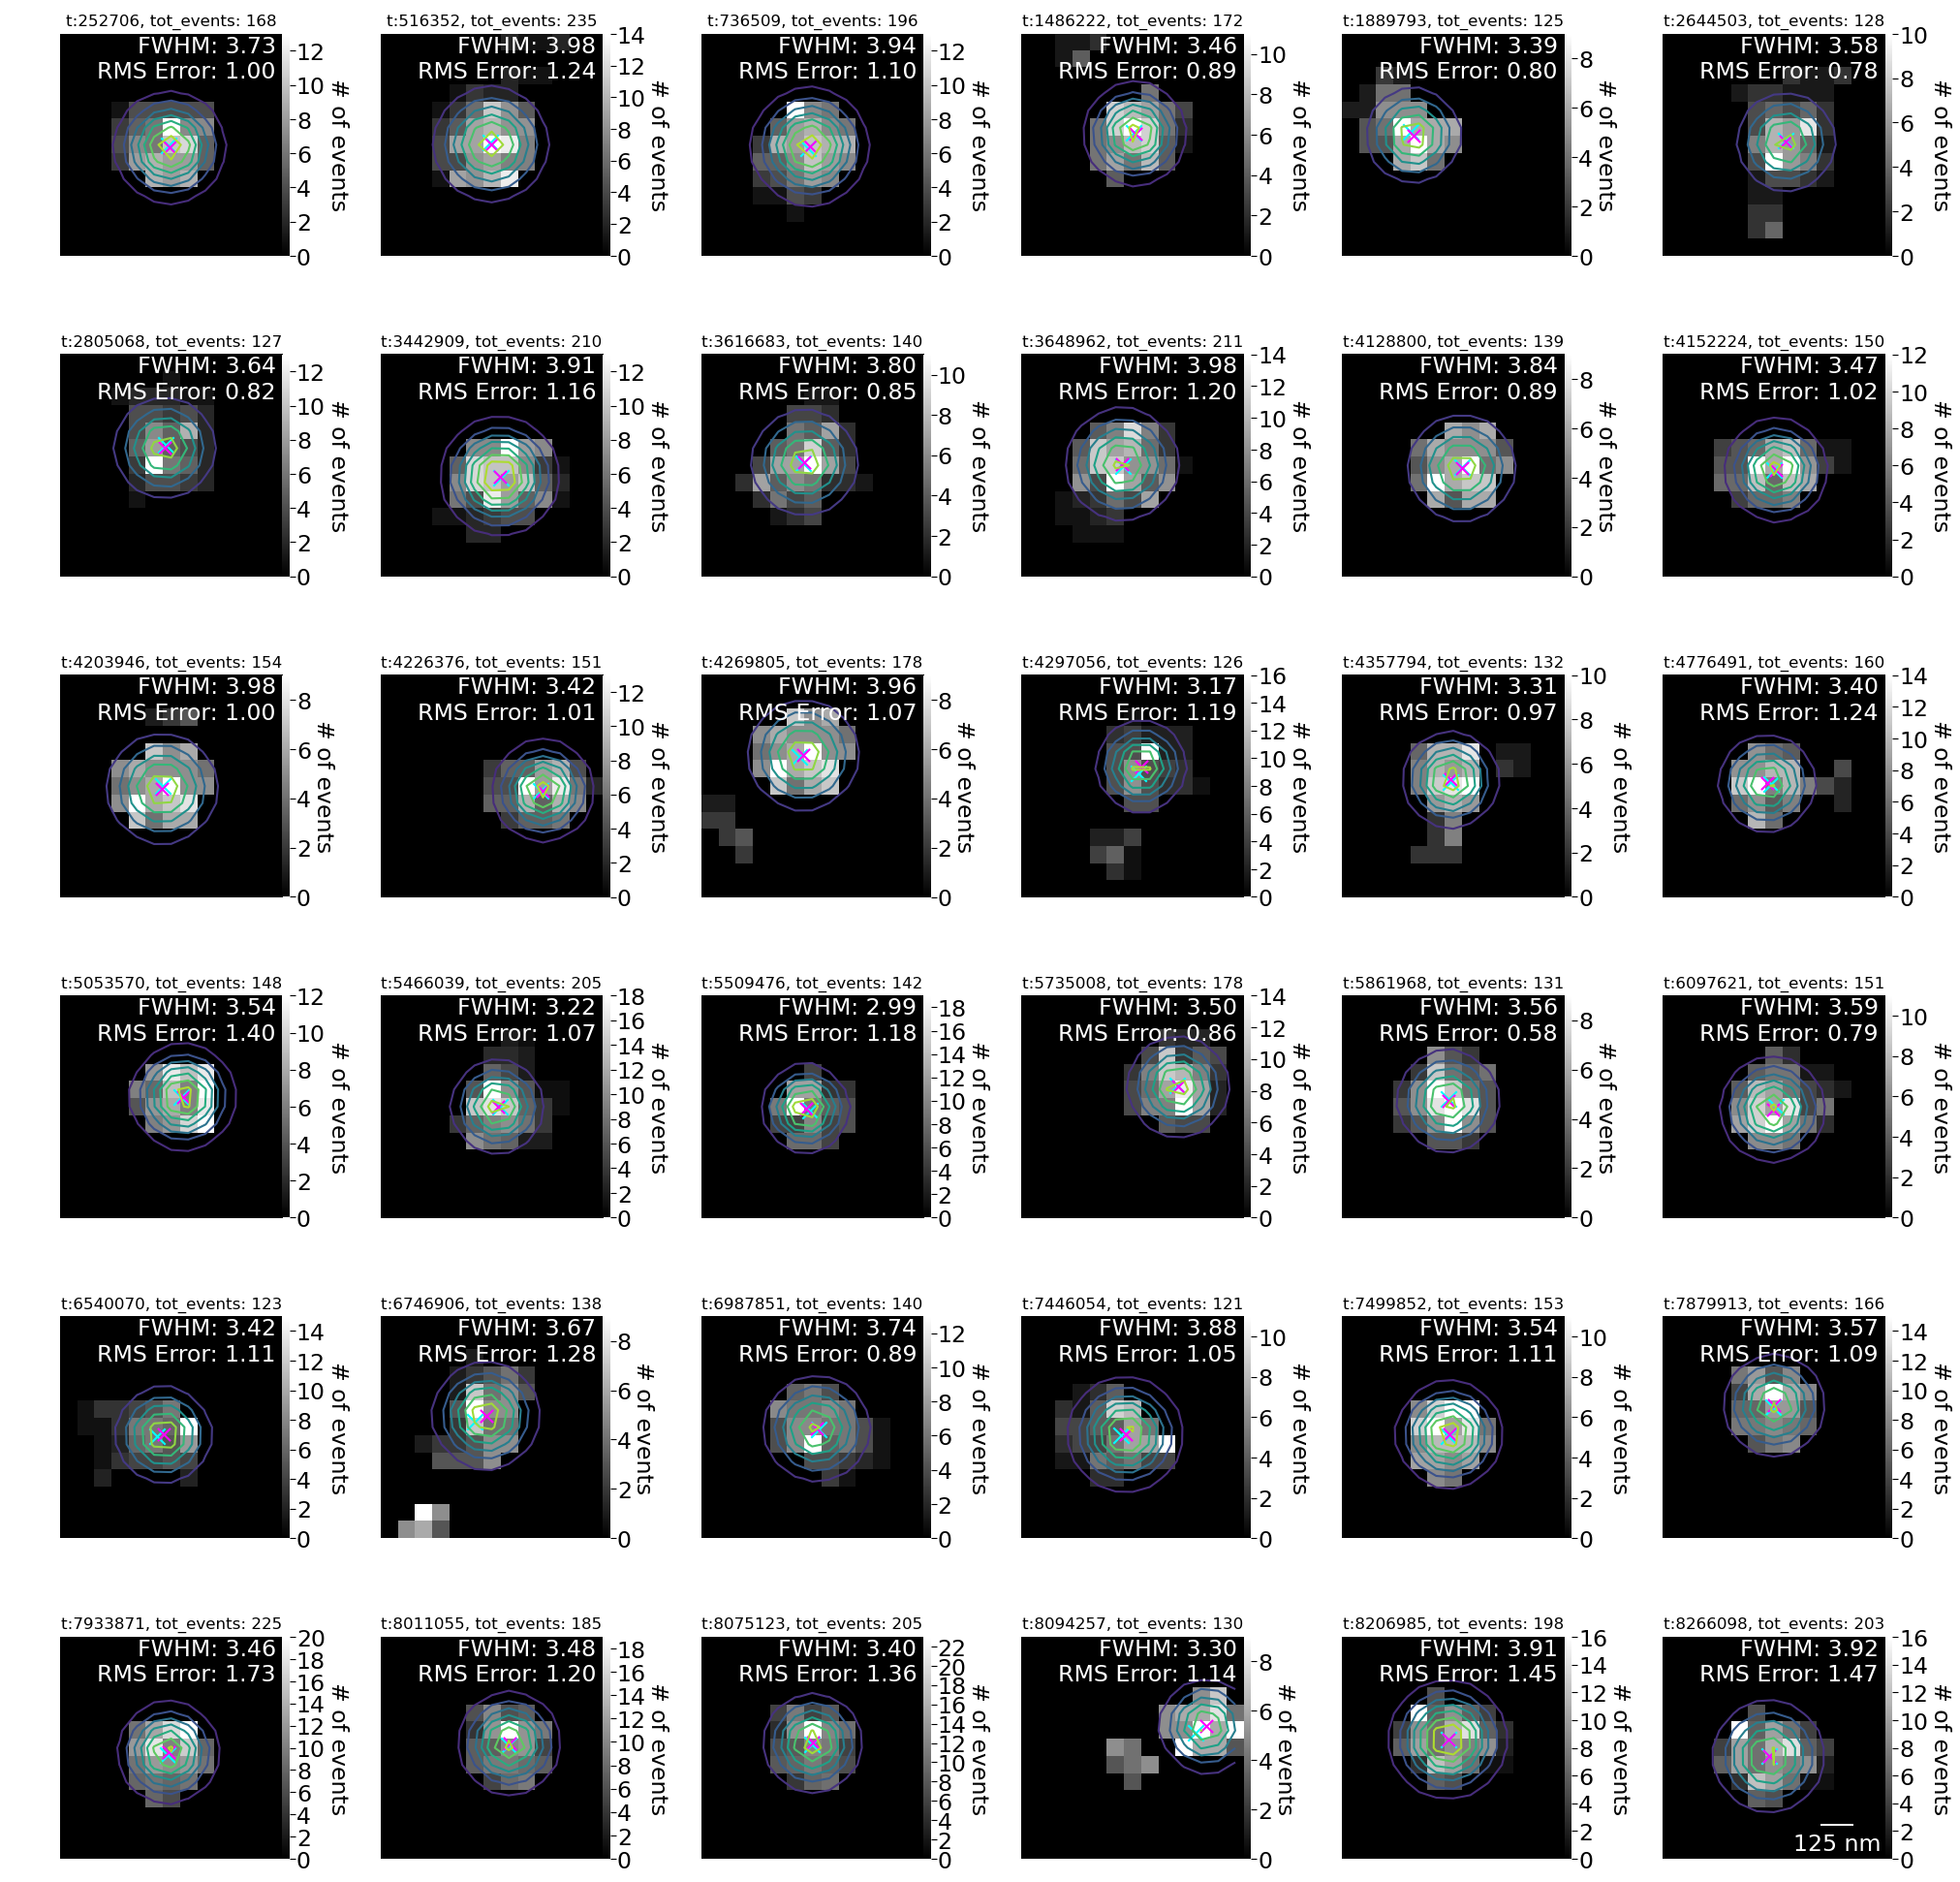

In [20]:
from localization_scripts.plotting_functions import plot_rois
rois2 = rois[rois['total_events_roi']>120]
plot_rois(rois2)

In [ ]:
# def localization_PSF(roi, dataset_FWHM=5.5):
#     fit_radius=ROI_RADIUS//1.2
#     edge=[int(np.round(ROI[0]))-fit_radius,int(np.round(ROI[1]))-fit_radius]
#     opt,err=gaussian_fitting(sub_events,edge)
#     y=opt[0]+edge[0]
#     x=opt[1]+edge[1]
#     t=np.mean(sub_events['t'])
#     msk=(sub_events['p']==1)
#     nb_up=np.sum(msk)
#     t_up=np.mean(sub_events['t'][msk])
#     msk=(sub_events['p']==0)
#     nb_down=np.sum(msk)
#     t_down=np.mean(sub_events['t'][msk])
#     return np.array([t,y,x,nb_up,nb_down,t_up,t_down])
from scipy import optimize
def gaussian_fitting(roi, dataset_FWHM=5.5):
    initial_guess=ROI_RADIUS,ROI_RADIUS,dataset_FWHM/2.35,np.max(roi),np.median(roi)
    errorfunction=lambda p:np.ravel(gaussian_symmetrical(*p)-roi)
    p_full = optimize.leastsq(errorfunction,initial_guess,gtol=1e-4,ftol=1e-4,full_output=True)
    p=p_full[0]
    fv=p_full[2]['fvec']
    ss_err=(fv**2).sum()
    ss_tot=((roi-roi.mean())**2).sum()
    err=ss_err/ss_tot    
    return p,err
yrange=np.arange(2*ROI_RADIUS+1)*1.
xrange=np.arange(2*ROI_RADIUS+1)*1.
def gaussian_symmetrical(y0,x0,width,height,offset):
    fX=np.exp(-(xrange-x0)**2/(2.*width**2))
    fY=np.exp(-(yrange-y0)**2/(2.*width**2))
    fY=fY.reshape(len(fY),1)
    return offset+height*fY*fX

